# 0. Introduction

In this notebook, I will go through my solution and analysis of the [Kaggle house prices prediction competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). The aim of this competition is to analyse 79 different features that describe every aspect of the residential homes in Ames, Iowa and subsequently make predictions on the final sale price of each home.

The key practice skills in this competition are:
- Creative feature engineering
- Advanced regression techniques like random forest and gradient boosting

I have made references to the following notebooks in the making of this notebook:
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by [Pedro Marcelino, PhD](https://www.kaggle.com/pmarcelino)
- [#1 House Prices Solution [top 1%]](https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1) by [Nanashi](https://www.kaggle.com/jesucristo)
- [How I made top 0.3% on a Kaggle competition](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#EDA) by [Lavanya Shukla](https://www.kaggle.com/lavanyashukla01)
- [Stacked Regressions: Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by [Serigne](https://www.kaggle.com/serigne)

# 1. Import libraries

These are the libraries that I will be using to perform my analysis and modelling. I have grouped them according to their functionalities.

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import norm, boxcox_normmax
from scipy.special import boxcox1p

# Modelling
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Miscellaneous
from collections import Counter

# 2. Import and read data

Import traning set, test set and sample submission.

In [2]:
train = pd.read_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/train.csv")
test = pd.read_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/test.csv")
ss = pd.read_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/sample_submission.csv")

Let's have a look at the datasets.

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Training set columns

train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
ss.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [7]:
# Combine training and test set

combine = pd.concat([train, test])

In [8]:
# All dataframe shape

print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)
print("Combined shape: ", combine.shape)
print("Sample submission shape: ", ss.shape)

Training set shape:  (1460, 81)
Test set shape:  (1459, 80)
Combined shape:  (2919, 81)
Sample submission shape:  (1459, 2)


# 3. Exploratory data analysis (EDA)

Exploratory data analysis involves analysing datasets in order to summarise their main characteristics. In this section, I will perform the following analysis:

- Descriptive statistics
- Check data types
- Feature analysis
- Examine missing data

## 3.1 Descriptive statistics

In [9]:
# Summary statistics for training set

train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [10]:
# Summary statistics for test set

test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1459.0,2190.000000,421.321334,1461.0,1825.50,2190.0,2554.50,2919.0
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0


## 3.2 Check data types

In [11]:
combine.dtypes.value_counts()

object     43
int64      26
float64    12
dtype: int64

There are 43 text variables and 38 numerical variables in the training set including Id and SalePrice.

## 3.3 Feature analysis

Feature analysis, as the name suggests, is analysing features or columns in the dataset and see how they correlate with our response variable that is the final sale price for each home.

## 3.3.1 Response (target) variable

In [12]:
# Summary statistics for sale price

train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Sale Price Distribution')

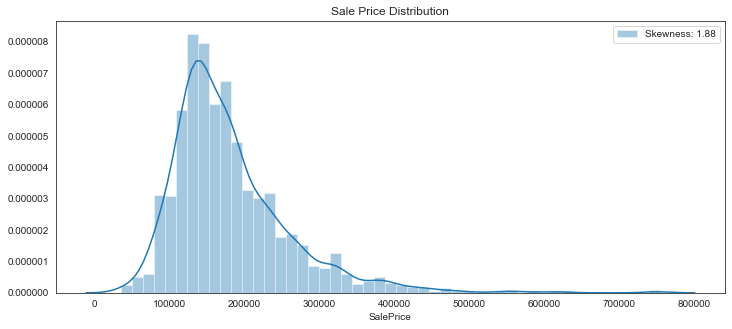

In [13]:
# Sale price distribution

plt.figure(figsize = (12, 5))
sns.set_style('white')
sns.distplot(train['SalePrice'], label = 'Skewness: %.2f'%train['SalePrice'].skew())
plt.legend(loc = 'best')
plt.title('Sale Price Distribution')

In [14]:
# Skewness and kurtosis

print("Skewness: %f"%train['SalePrice'].skew())
print("Kurtosis: %f"%train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## 3.3.2 Correlation between numerical variables

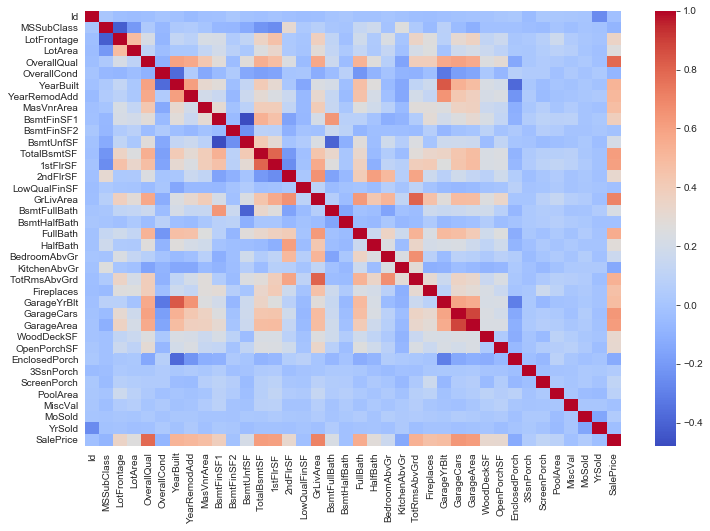

In [15]:
# Correlation between numerical variables

corr = combine.corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr, cmap = 'coolwarm')

Just by eyeballing the heatmap, we can observe signs of multicollinearity between some features. 

Multicollinearity can be observed in the following features:

- TotalBsmtSF and 1stFlrSF
- GarageCars and GarageArea
- GarageYrBlt and YearBuilt
- TotRmsAbvGrd and GrLivArea

In [16]:
# Features most correlated with sale price

corr['SalePrice'].sort_values(ascending = False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

We observe that many of the top 10 features that most correlated with sale price have correlation with each other.

Therefore, in the event of a correlated pair, I will choose to examine the feature that has a higher correlation with sale price. In other words:

- GrLivArea
- GarageCars
- TotalBsmtSF
- YearBuilt

## 3.3.3 Numerical variable: OverallQual

Text(0.5, 1, 'Sale Price Against Overall Quality')

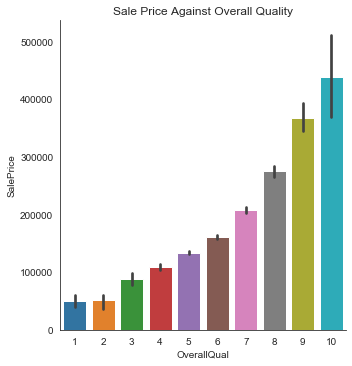

In [17]:
# Sale price against overall quality 

sns.set_style('white')
sns.factorplot(x = 'OverallQual', y = 'SalePrice', data = train, kind = 'bar')
plt.title('Sale Price Against Overall Quality')

Sale price increases with overall quality but we don't know how overall quality was calculated.

## 3.3.4 Numerical variable: GrLivArea

Text(0.5, 1.0, 'Sale Price Against GrLivArea')

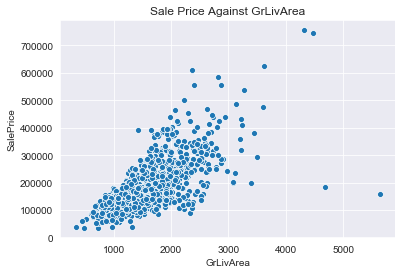

In [18]:
# Sale price against GrLivArea

sns.set_style('darkgrid')
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = train)
plt.title('Sale Price Against GrLivArea')

We observe two outliers in the scatter plot with large GrLivArea but low sale price. We need to address this later on by removing them from the training set.

## 3.3.5 Numerical variable: GarageCars

Text(0.5, 1, 'Sale Price Against Garage Cars')

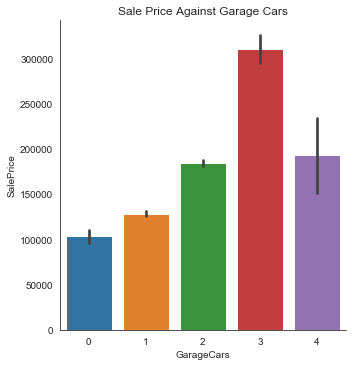

In [19]:
# Sale price against garage cars

sns.set_style('white')
sns.factorplot(x = 'GarageCars', y = 'SalePrice', data = train, kind = 'bar')
plt.title('Sale Price Against Garage Cars')

Houses with 3 garage cars have the highest sale price. 

## 3.3.6 Numerical variable: TotalBsmtSF

Text(0.5, 1.0, 'Sale Price Against TotalBsmtSF')

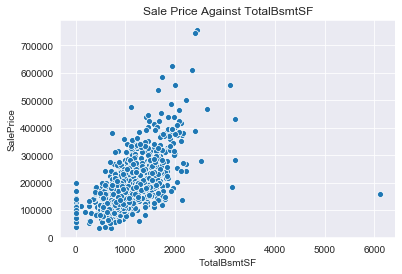

In [20]:
# Sale price against TotalBsmtSF

sns.set_style('darkgrid')
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice', data = train)
plt.title('Sale Price Against TotalBsmtSF')

Another outlier! The data point on the far right has a large TotalBsmtSF but a low sale price.

## 3.3.7 Numerical variable: FullBath

Text(0.5, 1, 'Sale Price Against Full Bath')

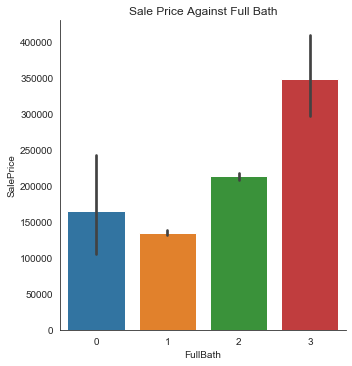

In [21]:
# Sale price against FullBath

sns.set_style('white')
sns.factorplot(x = 'FullBath', y = 'SalePrice', data = train, kind = 'bar')
plt.title('Sale Price Against Full Bath')

## 3.3.8 Numerical variable: YearBuilt

Text(0.5, 1.0, 'Sale Price Against Year Built')

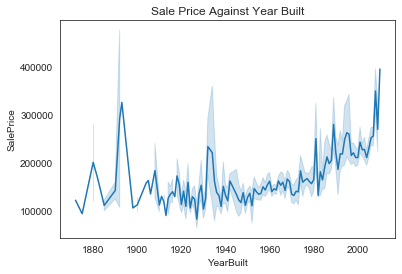

In [22]:
# Sale price against year built

sns.set_style('white')
sns.lineplot(x = 'YearBuilt', y = 'SalePrice', data = train)
plt.title('Sale Price Against Year Built')

House prices are trending upwards in general.

## 3.3.9 Mega scatter plot

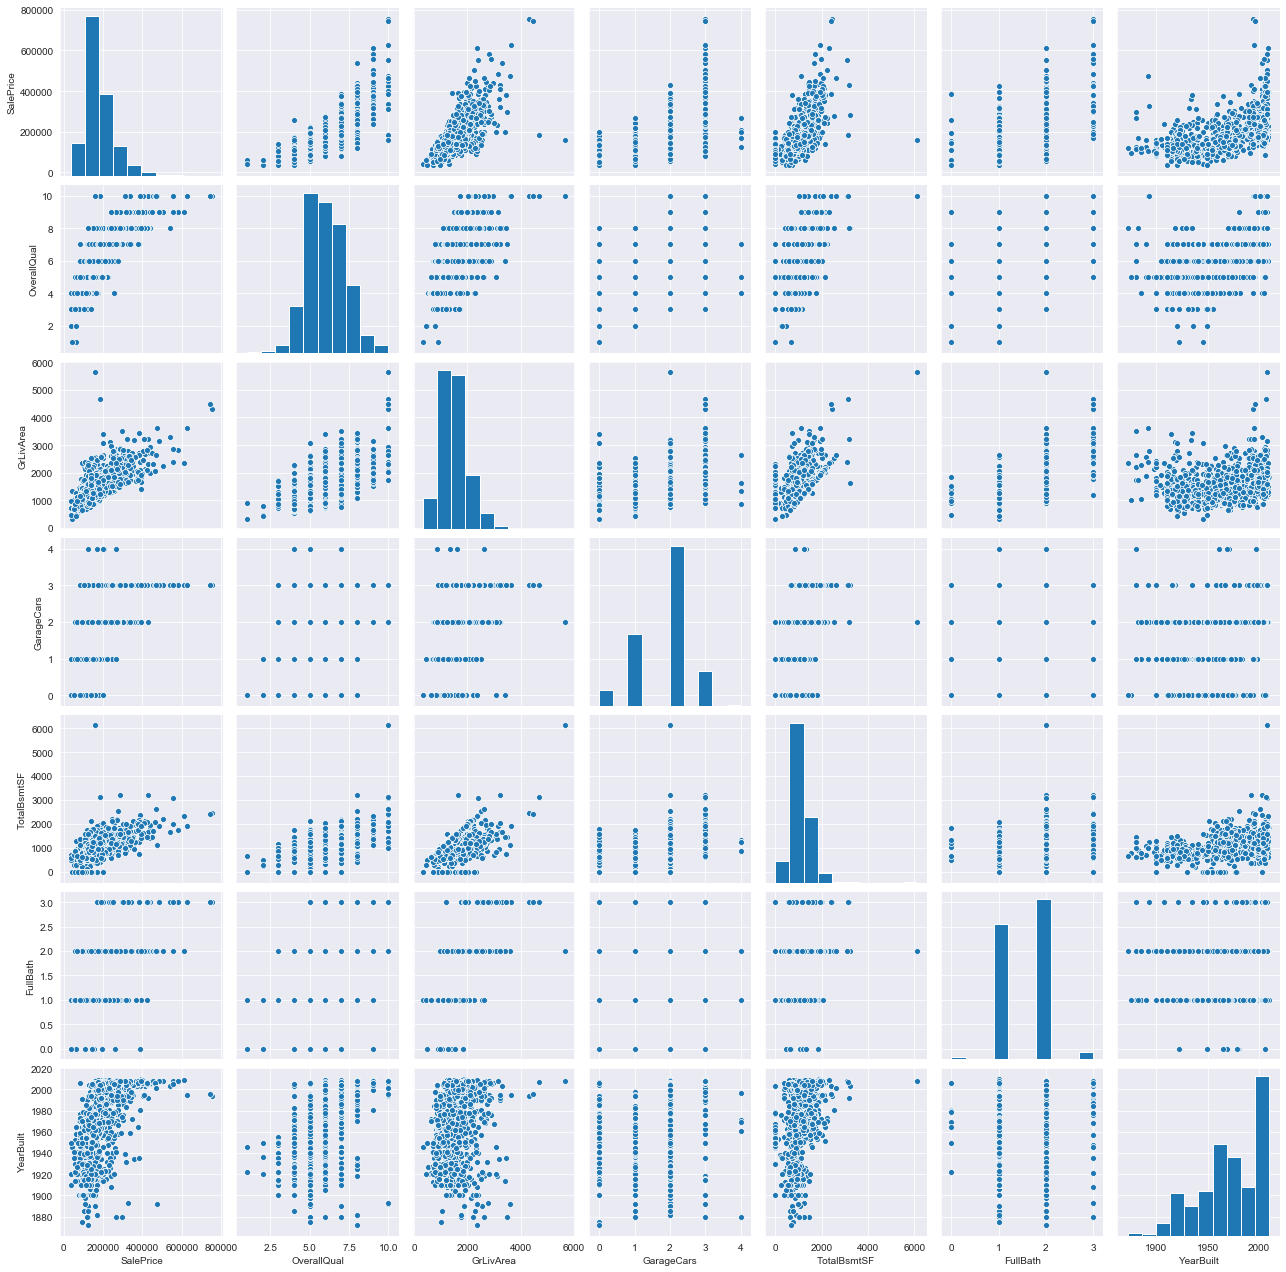

In [23]:
sns.set_style('darkgrid')
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])

## 3.4 Examine missing data

In [24]:
# Missing data in combined dataframe
missing = combine.isnull().sum()
missing = missing[missing > 0]

# Percentage missing
percent_missing = missing / len(combine)

# Concat missing and percentage missing
missing_df = pd.concat([missing, percent_missing], axis = 1, keys = ['Total', 'Percent'])

# Drop sale price because test set does not have sale price
missing_df = missing_df.drop('SalePrice')

# Create dataframe for missing data 
missing_df.sort_values(by = 'Total', ascending = False, inplace = True)
missing_df

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471
GarageYrBlt,159,0.054471


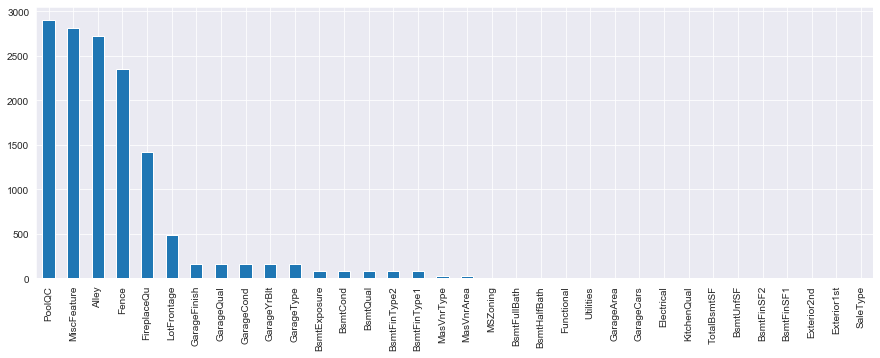

In [25]:
# Columns with missing data

plt.figure(figsize = (15, 5))
missing_df['Total'].plot(kind = 'bar')

In [26]:
print("Number of features with missing data in combined dataframe: ", len(missing_df))

Number of features with missing data in combined dataframe:  34


In [27]:
missing_features = missing_df.index
missing_features

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'BsmtFullBath', 'BsmtHalfBath',
       'Functional', 'Utilities', 'GarageArea', 'GarageCars', 'Electrical',
       'KitchenQual', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1',
       'Exterior2nd', 'Exterior1st', 'SaleType'],
      dtype='object')

# 4. Data preprocessing

Data preprocessing is the process behind getting our datasets ready for model training. In this section, I will be performing the following preprocessing tasks:

- Impute missing values
- Detect and remove outliers
- Apply log transformation to sale price
- Apply Box-Cox transformation to features with high skewness
- Feature engineering
- Encode categorical variables

## 4.1 Impute missing values

Let's first deal with features that are related to:
- Garage
- Basement
- Masonry veneer

I will make an underlying assumption that the reason behind these missing values is because some houses simply do not have those features.

## 4.1.1 Missing values in garage

In [28]:
# Get missing features that are related to garage

garage_features = [feature for feature in missing_features if 'Garage' in feature]
garage_features

['GarageFinish',
 'GarageQual',
 'GarageCond',
 'GarageYrBlt',
 'GarageType',
 'GarageArea',
 'GarageCars']

In [29]:
# Check data types of garage features

combine[garage_features].dtypes

GarageFinish     object
GarageQual       object
GarageCond       object
GarageYrBlt     float64
GarageType       object
GarageArea      float64
GarageCars      float64
dtype: object

We have 3 numerical garage features and 4 categorical garage features.

I will fill the numerical garage features with 0 and the categorcial garage features with None.

In [30]:
# Fill missing garage features

for feature in garage_features:
    if combine[feature].dtype == 'object':
        combine[feature] = combine[feature].fillna('None')
    else:
        combine[feature] = combine[feature].fillna(0)

## 4.1.2 Missing values in basement

In [31]:
# Get missing features that are related to basement

basement_features = [feature for feature in missing_features if 'Bsmt' in feature]
basement_features

['BsmtExposure',
 'BsmtCond',
 'BsmtQual',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtFullBath',
 'BsmtHalfBath',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtFinSF1']

In [32]:
# Check data types of basement features

combine[basement_features].dtypes

BsmtExposure     object
BsmtCond         object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
BsmtFullBath    float64
BsmtHalfBath    float64
TotalBsmtSF     float64
BsmtUnfSF       float64
BsmtFinSF2      float64
BsmtFinSF1      float64
dtype: object

Again, fill numerical basement features with 0 and categorical with None.

In [33]:
# Fill missing basement features

for feature in basement_features:
    if combine[feature].dtype == 'object':
        combine[feature] = combine[feature].fillna('None')
    else:
        combine[feature] = combine[feature].fillna(0)

## 4.1.3 Missing values in masonry veneer

In [34]:
# Get missing features that are related to masonry veneer

mv_features = [feature for feature in missing_features if 'MasVnr' in feature]
mv_features

['MasVnrType', 'MasVnrArea']

In [35]:
# Check data types of masonry veneer features

combine[mv_features].dtypes

MasVnrType     object
MasVnrArea    float64
dtype: object

In [36]:
for feature in mv_features:
    if combine[feature].dtype == 'object':
        combine[feature] = combine[feature].fillna('None')
    else:
        combine[feature] = combine[feature].fillna(0)

## 4.1.4 Other missing values

After checking the data description on the Kaggle competition page, I have decided to fill the missing values in the following columns with None:

- PoolQC
- MiscFeature
- Alley
- Fence
- FireplaceQu

Again, the assumption here is that some houses do not have these features.

In [37]:
# Fill features with None

other_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
for feature in other_features:
    combine[feature] = combine[feature].fillna('None')

Let's check our missing values again.

In [38]:
missing = combine.isnull().sum()
missing = missing[missing > 0]
missing = missing.drop('SalePrice')
missing.sort_values(ascending = False, inplace = True)
missing

LotFrontage    486
MSZoning         4
Functional       2
Utilities        2
SaleType         1
KitchenQual      1
Electrical       1
Exterior2nd      1
Exterior1st      1
dtype: int64

In [39]:
# Check data types of the remaining missing features

missing_features = list(missing.index)
combine[missing_features].dtypes

LotFrontage    float64
MSZoning        object
Functional      object
Utilities       object
SaleType        object
KitchenQual     object
Electrical      object
Exterior2nd     object
Exterior1st     object
dtype: object

Here is the game plan for the remaining features:

- Group the houses by Neighborhood and fill the missing values in LotFrontage with the median LotFrontage according to Neighborhood
- Group the houses by MSSubClass and fill the missing values in MSZoning with the most frequent (mode) MSZoning
- Since we do not have any information on the remaining categorical features, simply fill with mode of that column

In [40]:
# LotFrontage
combine['LotFrontage'] = combine.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# MSZoning
combine['MSZoning'] = combine.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# Remaining features
missing_features.remove('LotFrontage')
missing_features.remove('MSZoning')
for feature in missing_features:
    combine[feature] = combine[feature].fillna(combine[feature].mode()[0])

In [41]:
# Make sure there is no more missing data

combine.drop('SalePrice', axis = 1).isnull().sum().max()

0

## 4.2 Detect and remove outliers

In [42]:
# Split training and test set from combined dataframe

train = combine[:len(train)]
test = combine[len(train):]

In [43]:
# Drop sale price from test set

test = test.drop('SalePrice', axis = 1)

In [44]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)

Training set shape:  (1460, 81)
Test set shape:  (1459, 80)


In [45]:
# Get numerical features from training set 
numerical_features = [feature for feature in train if train[feature].dtype != 'object']

# Remove Id and SalePrice
numerical_features.remove('Id')
numerical_features.remove('SalePrice')

In [46]:
numerical_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [47]:
# Detect outliers using Tukey method

def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 6, numerical_features)
print(f"We are dropping {len(outliers_to_drop)} observations.")

We are dropping 9 observations.


In [48]:
train.iloc[outliers_to_drop]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,None,None,None,0,3,2007,WD,Abnorml,200000.0
197,198,75,RL,174.0,25419,Pave,None,Reg,Lvl,AllPub,...,512,Ex,GdPrv,None,0,3,2006,WD,Abnorml,235000.0
523,524,60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,...,0,None,None,None,0,10,2007,New,Partial,184750.0
1173,1174,50,RL,138.0,18030,Pave,None,IR1,Bnk,AllPub,...,0,None,MnPrv,None,0,3,2007,WD,Normal,200500.0
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000.0
1298,1299,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,...,480,Gd,None,None,0,1,2008,New,Partial,160000.0
185,186,75,RM,90.0,22950,Pave,None,IR2,Lvl,AllPub,...,0,None,GdPrv,None,0,6,2006,WD,Normal,475000.0
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000.0
1386,1387,60,RL,80.0,16692,Pave,None,IR1,Lvl,AllPub,...,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000.0


In [49]:
# Drop outliers and reset index

print(f"Before: {len(train)} rows")
train = train.drop(outliers_to_drop).reset_index(drop = True)
print(f"After: {len(train)} rows")

Before: 1460 rows
After: 1451 rows


## 4.2.1 Make sure outliers have been removed from GrLivArea and TotalBsmtSF

Text(0.5, 1.0, 'Sale Price Against GrLivArea')

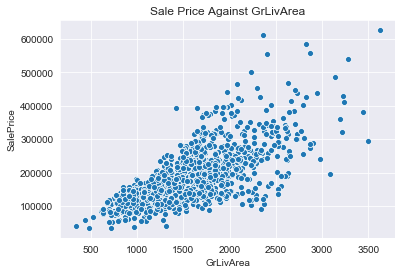

In [50]:
# Sale price against GrLivArea

sns.set_style('darkgrid')
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = train)
plt.title('Sale Price Against GrLivArea')

Text(0.5, 1.0, 'Sale Price Against TotalBsmtSF')

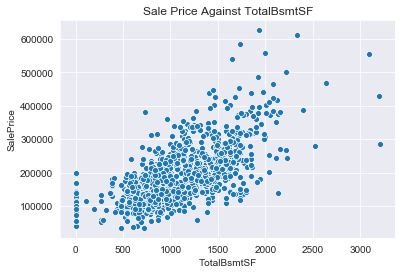

In [51]:
# Sale price against TotalBsmtSF

sns.set_style('darkgrid')
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice', data = train)
plt.title('Sale Price Against TotalBsmtSF')

Outliers that we have detected previously during exploratory data analysis have been removed.

## 4.3 Apply log transformation to sale price

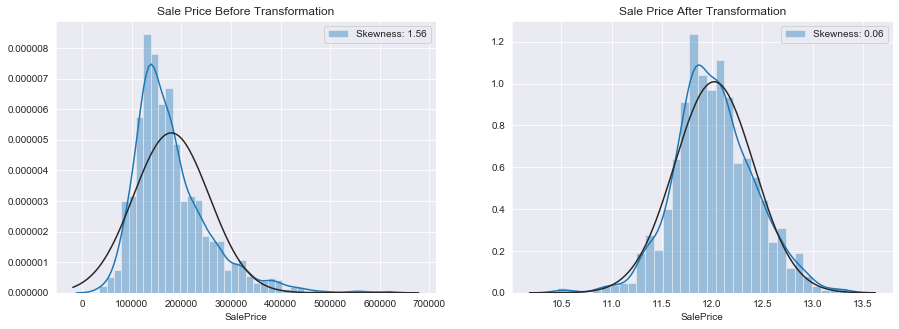

In [52]:
# Create axes to draw plots
fig, ax = plt.subplots(1, 2)

# Plot original SalePrice distribution
sns.distplot(train['SalePrice'], fit = norm, label = 'Skewness: %.2f'%train['SalePrice'].skew(), ax = ax[0])
ax[0].legend(loc = 'best')
ax[0].title.set_text('Sale Price Before Transformation')

# Apply box-cox transformation
train['SalePrice'] = np.log1p(train['SalePrice'])

# Plot transformed SalePrice distribution
sns.distplot(train['SalePrice'], fit = norm, label = 'Skewness: %.2f'%train['SalePrice'].skew(), ax = ax[1])
ax[1].legend(loc = 'best')
ax[1].title.set_text('Sale Price After Transformation')

# Rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(15)

## 4.4 Apply Box-Cox transformation to numerical features with high skewness 

In [53]:
# Combine training and test set 

combine = pd.concat([train, test])

In [54]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)
print("Combined shape: ", combine.shape)

Training set shape:  (1451, 81)
Test set shape:  (1459, 80)
Combined shape:  (2910, 81)


In [55]:
skew_features = combine[numerical_features].apply(lambda x: x.skew()).sort_values(ascending = False)
high_skew = skew_features[skew_features > 0.5]
print(f"There are {len(high_skew)} numerical features with skew greater than 0.5. ")
high_skew

There are 26 numerical features with skew greater than 0.5. 


MiscVal          22.047916
PoolArea         21.196819
LowQualFinSF     13.416755
LotArea          13.176425
3SsnPorch        11.363981
KitchenAbvGr      4.315158
BsmtFinSF2        4.164170
BsmtHalfBath      3.955531
EnclosedPorch     3.953261
ScreenPorch       3.902134
MasVnrArea        2.600193
OpenPorchSF       2.537419
WoodDeckSF        1.847518
MSSubClass        1.374974
1stFlrSF          1.257911
LotFrontage       1.067293
BsmtFinSF1        0.975355
GrLivArea         0.947840
BsmtUnfSF         0.923233
2ndFlrSF          0.842849
Fireplaces        0.727687
TotRmsAbvGrd      0.702998
HalfBath          0.699605
TotalBsmtSF       0.666376
BsmtFullBath      0.623406
OverallCond       0.565995
dtype: float64

In [56]:
# Normalise skewed features

for feature in high_skew.index:
    combine[feature] = boxcox1p(combine[feature], boxcox_normmax(combine[feature] + 1))

## 4.5 Feature engineering

Feature engineering entails creating new features from existing features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

In [57]:
# Let's have a look at our existing features

combine.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

I am creating 17 new features as follows:

- UnfBsmt
- HasWoodDeck
- HasOpenPorch
- HasEnclosedPorch
- Has3SsnPorch
- HasScreenPorch
- YearsSinceRemodel
- TotalHomeQuality
- TotalSF
- YearBuiltAndRemodel
- TotalBathrooms
- TotalPorchSF
- HasPool
- Has2ndFloor
- HasGarage
- HasBsmt
- HasFireplace

In [58]:
print(f"Before: {combine.shape[1]} columns")

combine['UnfBsmt'] = (combine['BsmtFinType1'] == 'Unf') * 1
combine['HasWoodDeck'] = (combine['WoodDeckSF'] == 0) * 1
combine['HasOpenPorch'] = (combine['OpenPorchSF'] == 0) * 1
combine['HasEnclosedPorch'] = (combine['EnclosedPorch'] == 0) * 1
combine['Has3SsnPorch'] = (combine['3SsnPorch'] == 0) * 1
combine['HasScreenPorch'] = (combine['ScreenPorch'] == 0) * 1
combine['YearsSinceRemodel'] = combine['YrSold'].astype(int) - combine['YearRemodAdd'].astype(int)
combine['TotalHomeQuality'] = combine['OverallQual'] + combine['OverallCond']
combine['TotalSF'] = combine['TotalBsmtSF'] + combine['1stFlrSF'] + combine['2ndFlrSF']
combine['YearBuiltAndRemodel'] = combine['YearBuilt'] + combine['YearRemodAdd']
combine['TotalBathrooms'] = combine['FullBath'] + combine['BsmtFullBath'] + 0.5 * (combine['HalfBath'] + combine['BsmtHalfBath'])
combine['TotalPorchSF'] = combine['OpenPorchSF'] + combine['3SsnPorch'] + combine['EnclosedPorch'] + combine['ScreenPorch'] + combine['WoodDeckSF']
combine['HasPool'] = combine['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
combine['Has2ndFloor'] = combine['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
combine['HasGarage'] = combine['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
combine['HasBsmt'] = combine['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
combine['HasFireplace'] = combine['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print(f"After: {combine.shape[1]} columns")

Before: 81 columns
After: 98 columns


## 4.6 Encode categorical features

Assign numerical values to categorical variables because most models can only handle numerical features.

In [59]:
print("Before: ", combine.shape)
combine = pd.get_dummies(combine)
print("After: ", combine.shape)

Before:  (2910, 98)
After:  (2910, 319)


# 5. Modelling

In this section, I will fit 8 different machine learning models to the training set and use the best performing model to make predictions on the test set. The best performing or most accurate model is defined as the model with the lowest root mean squared error during cross-validation.

## 5.1 Get the new training and test set

In [60]:
train = combine[:len(train)]
test = combine[len(train):]

In [61]:
X_train = train.drop(['Id', 'SalePrice'], axis = 1)
Y_train = train['SalePrice']
X_test = test.drop(['Id', 'SalePrice'], axis = 1)
test_id = test['Id']

In [62]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (1451, 317)
Y_train shape:  (1451,)
X_test shape:  (1459, 317)


## 5.2 Define cross-validation strategy and evaluation metrics

In [63]:
# Cross validation

kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

In [64]:
# Evaluation metrics

def cv_rmse(model, X = X_train, y = Y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kfolds))
    return rmse

## 5.3 Model evaluation

I will be using the following regressors for modelling:

- Ridge
- Lasso
- Elastic net
- Random forest
- Support vector regressor
- Gradient boosting
- Light GBM
- XGBoost

In [65]:
# Instantiate regressors

ridge = make_pipeline(RobustScaler(), RidgeCV())
lasso = make_pipeline(RobustScaler(), LassoCV())
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV())
rf = RandomForestRegressor()
svr = SVR()
gbr = GradientBoostingRegressor()
lightgbm = LGBMRegressor()
xgboost = XGBRegressor()

In [66]:
models = [ridge, lasso, elasticnet, rf, svr, gbr, lightgbm, xgboost]
mean = []
std = []
for model in models:
    mean.append(cv_rmse(model).mean())
    std.append(cv_rmse(model).std())

models_df = pd.DataFrame({'Model': ['Ridge', 'Lasso', 'Elastic Net', 'Random Forest', 'SVR', 'Gradient Boosting', 'Light GBM', 'XGBoost'],
                         'Mean': mean, 'Std': std})
models_df.sort_values(by = 'Mean', inplace = True, ignore_index = True)

[10:21:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [67]:
models_df

,Model,Mean,Std
0,Ridge,0.108821,0.014678
1,Lasso,0.111483,0.018170
2,Elastic Net,0.111738,0.018194
3,Gradient Boosting,0.122066,0.012576
4,XGBoost,0.122634,0.014582
5,Light GBM,0.124947,0.014556
6,Random Forest,0.134219,0.015700
7,SVR,0.190251,0.018413


Since Ridge has the lowest root mean squared error, I will use this model to predict the data in the test set and save a copy of the predictions.

## 5.4 Make predictions on test data using Ridge

In [68]:
ridge_model = ridge.fit(X_train, Y_train)
Y_pred = ridge_model.predict(X_test)
len(Y_pred)

1459

In [69]:
ss.shape

(1459, 2)

In [70]:
ss.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [71]:
ridge_submission = pd.DataFrame({'Id': test_id, 'SalePrice': np.expm1(Y_pred)})
ridge_submission.head()

,Id,SalePrice
0,1461,117572.549015
1,1462,156062.775148
2,1463,185026.425659
3,1464,200000.165018
4,1465,192791.561148


In [72]:
# Save ridge submission

ridge_submission.to_csv("C:/Users/Jason Chong/Documents/Kaggle/house-prices/ridge_submission.csv", index = False)

# 6. Conclusion

My predictions resulted in a submission score of 0.12550 when submitted to Kaggle.

If you found any mistakes in the notebook or places where I can potentially improve on, feel free to provide me with some feedback. Happy learning!

My platforms:

- [Facebook](https://www.facebook.com/chongjason914)
- [Instagram](https://www.instagram.com/chongjason914)
- [Twitter](https://www.twitter.com/chongjason914)
- [LinkedIn](https://www.linkedin.com/in/chongjason914)
- [YouTube](https://www.youtube.com/channel/UCQXiCnjatxiAKgWjoUlM-Xg?view_as=subscriber)
- [Medium](https://www.medium.com/@chongjason)